# Setup

In [137]:
from collections import defaultdict, Counter
from datetime import datetime
# import glob
import matplotlib.pyplot as plt
import numpy as np
# import os
import pandas as pd
# from scipy.interpolate import make_interp_spline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Iterable
import xgboost as xgb
from xgboost import XGBRegressor

In [50]:
KEEP_CATEGORY_DFS = False
KEEP_SETS = False
DROPS = {
    'movie_name',
    'description',
    'director',
    'star'
}

EXPLORE = False # Whether to execute the data exploration cells

# NOTE: filters
F_RUNTIME = (30, 300) # min-max runtime in minutes
F_YEAR = (1920, 2020) # min-max year
F_COLS = [ # Require all rows to contain values in these columns
    'certificate',
    'gross_usd',
    'rating',
    # 'runtime',
    'votes',
    # 'year'
]

In [4]:
# NOTE: Combining the CSVs as below is not used anymore, as the data is dealt with in DataFrames before concatenation.
"""
# Get all CSV file paths in the folder
csv_files = glob.glob(os.path.join("Data", '*.csv'))

# Combine them
combined_df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Save the result
combined_df.to_csv('movies.csv', index=False)

print(f"Combined {len(csv_files)} files into 'movies.csv'.")
"""

categories = {
    'action',
    'adventure',
    'animation',
    'biography',
    'crime',
    'family',
    'fantasy',
    'film_noir',
    'history',
    'horror',
    'mystery',
    'romance',
    'scifi',
    'sports',
    'thriller',
    'war'
}

# Yes, this one is a list rather than a set:
    # index is important. In general,
    # closer to the start of the list
    # means more "child-friendly,"
    # though the order is somewhat arbitrary.
certificates = [
    # NOTE: Ambiguous
    'Approved',  # Old MPAA term
    'Passed',    # Old UK/US approval term
    'Open',      # Possibly meaning open rating?
    'F',         # Ambiguous (could be festival, or female—don't ask me lol)

    # NOTE: Young Audiences
    'TV-Y',      # All Children
    'TV-Y7',     # Directed to Older Children
    'TV-Y7-FV',  # Includes fantasy violence
    'TV-G',      # General Audience
    'G',         # General Audience (MPAA)
    'U',         # Universal
    'All',       # All Ages
    'E',         # Everyone (ESRB)
    '7',         # Age 7+
    'UA 7+'      # Universal Adult 7+ (India)
    'E10+',      # Everyone 10+ (ESRB)

    # NOTE: General Audiences & Young Teens
    'PG',        # Parental Guidance (MPAA)
    'TV-PG',     # Parental Guidance
    'GP',        # Parental Guidance (older term)
    'UA',        # Parental Guidance (India)
    'TV-13',     # Age 13+
    '13+',       # Age 13+
    'UA 13+',    # Parental Guidance 13+ (India)
    'PG-13',     # Parental Guidance 13+ (MPAA)
    'M/PG',      # Mature / Parental Guidance
    'MA-13',     # Mature Audience 13+
    'TV-14',     # Age 14+
    'T',         # Teen (ESRB)

    # NOTE: Mature Teens & Young Adults
    '16',        # Age 16
    '16+',       # Age 16+
    'UA 16+',    # Age 16+ (India)
    'M',         # Mature (ESRB)
    'MA-17',     # Mature Audience 17+
    'R',         # Restricted (MPAA)

    # NOTE: Mature Adults
    'NC-17',     # No children under 17
    '18',        # Age 18
    '18+',       # Age 18+
    'TV-MA',     # Mature Audience
    'X',         # Explicit (MPAA)
    'A',         # Adults (ESRB)
    'AO',        # Adults Only (ESRB)

    # NOTE: Special Cases
    'Not Rated', # Never submitted for a rating
    'Unrated',   # Often an "extended cut," where the original was rated but the extended version was not.
]

In [5]:
""" NOTE: Rather than defining each category DataFrame manually, the loop below defines them dynamically.
action = pd.read_csv('Data/action.csv')
adventure = pd.read_csv('Data/adventure.csv')
animation = pd.read_csv('Data/animation.csv')
biography = pd.read_csv('Data/biography.csv')
crime = pd.read_csv('Data/crime.csv')
family = pd.read_csv('Data/family.csv')
fantasy = pd.read_csv('Data/fantasy.csv')
film_noir = pd.read_csv('Data/film_noir.csv')
history = pd.read_csv('Data/history.csv')
horror = pd.read_csv('Data/horror.csv')
mystery = pd.read_csv('Data/mystery.csv')
romance = pd.read_csv('Data/romance.csv')
scifi = pd.read_csv('Data/scifi.csv')
sports = pd.read_csv('Data/sports.csv')
thriller = pd.read_csv('Data/thriller.csv')
war = pd.read_csv('Data/war.csv')
"""

for category in categories:
    # Dynamically read each CSV file into a pd.DataFrame based on the category name
        # and assign it to a global variable with the same name as the category
    globals()[category] = pd.read_csv(f"Data/{category}.csv")
    globals()[category].rename(columns={'gross(in $)': 'gross_usd'}, inplace=True)

del category

# globals()['action'].head(10)

## Data Preparation

In [6]:
def split_listlikes(df: pd.DataFrame, splits: Iterable, make_sets: bool) -> None:
    """
    Cleans and splits specified columns in a DataFrame.
    
    Parameters:
        df: The DataFrame to process.
        splits: List of columns to split and clean.
        make_sets: If `True`, creates a set of unique values for each column.
    
    Returns:
        None: The function modifies the DataFrame in place.
    """

    def split_multiples(df: pd.DataFrame, col: str) -> None:
        """
        Splits the values in a column by `,` and stores them in a new column, as a list.

        Parameters:
            df: The DataFrame to process.
            col: The column to split.
        
        Returns:
            None: The function modifies the DataFrame in place.
        """

        df[col + 's'] = \
            df[col].apply(
                lambda x: {val.strip().lower() for val in x.split(',')}
                    if pd.notnull(x) 
                    else None)
        
    def trim_name_urls(df: pd.DataFrame, col: str) -> None:
        """
        Trims name URLs to just the important part.
        This is used for director and star names.
        
        i.e. `'/name/nm0000001/'` becomes `'nm0000001'`
        
        Parameters:
            df: The DataFrame to process.
            col: The column to trim.
        
        Returns:
            None: The function modifies the DataFrame in place.
        """

        df[col] = df[col].apply(
            lambda s: {x.split('/')[-2].strip() for x in s}
                if isinstance(s, set) and len(s) > 0
                else s)

    if make_sets:
        def track_uniques(df: pd.DataFrame, col: str, unique_set: set) -> None:
            
            """
            Tracks unique values in a column and stores them in a set.

            Parameters:
                df: The DataFrame to process.
                col: The column to track unique values from.
                unique_set: A set to store unique values.
            
            Returns:
                None: The function modifies the set in place.
            """

            for items in df[col + 's'].dropna():
                # Add each item to the set
                for item in items:
                    unique_set.add(item)

    ##########

    for col in splits:
        col_s = col + 's'
        try:
            # Split the column values by ',' and store in a new column
            split_multiples(df, col)

            # Trim name URLs for director and star names if applicable
            if col_s in ['director_ids', 'star_ids']:
                trim_name_urls(df, col_s)
            elif col_s == 'genres':
                # Convert genres to lowercase
                g = {df['category'][0]}
                df[col_s] = df[col_s].apply(lambda s: s | g)
                df.drop(columns=['category'], inplace=True)

            if make_sets:
                # Track unique values for each column
                globals()[col_s] = set()
                track_uniques(df, col, globals()[col_s])

            df.drop(columns=[col], inplace=True) # Drop the original column to save space
        except KeyError:
            # Handle the case where the column might not exist in the DataFrame (i.e. this function has already been performed)
            print(f"Column '{col}' not found in DataFrame.")

            if make_sets:
                # Initialize an empty set to avoid errors later on
                if col_s not in globals():
                    globals()[col_s] = set()

def clean_runtime(df: pd.DataFrame) -> None:
    """
    Cleans the runtime column in the DataFrame.
    
    Parameters:
        df: The DataFrame to process.
    
    Returns:
        None: The function modifies the DataFrame in place.
    """

    # Convert runtime to numeric values (in minutes)
    df['runtime'] = df['runtime'].apply(
        lambda x: int(x.split()[0].replace(',', '')) if pd.notnull(x) else None)

def convert_year(df: pd.DataFrame) -> None:
    """
    Converts the year column to numeric values.
    
    Parameters:
        df: The DataFrame to process.
    
    Returns:
        None: The function modifies the DataFrame in place.
    """

    def _convert(x):
        """Helper function to convert year to int or None."""
        try:
            return int(x)
        except (ValueError, TypeError):
            return None
        
    df['year'] = df['year'].apply(
        lambda x: _convert(x) if pd.notnull(x) else None)

''' NOTE: Replaced with map_certs below
# def one_hot_cert(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     One-hot encodes the 'certificate' column in the DataFrame.
    
#     Parameters:
#         df: The DataFrame to process.
    
#     Returns:
#         pd.DataFrame: This one can't be modified in-place,
#             so it returns the new df.
#     """

#     # One-hot encode the 'certificate' column
#     ohe_certs = pd.get_dummies(df['certificate'], prefix='cert', drop_first=True)
#     df.drop(columns=['certificate'], inplace=True) # Drop the original column
#     return df.join(ohe_certs, how='left') # Join the dummies back to the main DataFrame
'''

def map_certs(df: pd.DataFrame) -> None:
    """
    Maps the 'certificate' column to numeric values.
    
    Parameters:
        df: The DataFrame to process.
    
    Returns:
        None: The function modifies the DataFrame in place.
    """

    # Map the certificate values to numeric values
    df['certificate'] = df['certificate'].apply(
        lambda x: certificates.index(x) + 1 if x in certificates else 0)

def score_people(df: pd.DataFrame) -> None:
    """
    Encodes the 'director_ids' and 'star_ids' columns in the DataFrame.
    The columns added are "scores," representing a combination of both
        how often that person appears in the dataset and their average rating.

    Parameters:
        df: The DataFrame to process.

    Returns:
        None: The function modifies the DataFrame in place.
    """

    # Target encoding
    director_ratings = defaultdict(list)
    star_ratings = defaultdict(list)

    for _, row in df.iterrows():
        directors = row['director_ids'] or set()
        stars = row['star_ids'] or set()
        for d in directors:
            director_ratings[d].append(row['rating'])
        for s in stars:
            star_ratings[s].append(row['rating'])

    director_avg_rating = {d: sum(r)/len(r) for d, r in director_ratings.items()}
    star_avg_rating = {s: sum(r)/len(r) for s, r in star_ratings.items()}

    # Frequency encoding
    director_freq = Counter(d for ds in df['director_ids'].dropna() for d in ds)
    star_freq = Counter(s for ss in df['star_ids'].dropna() for s in ss)

    # Combine both scores
    def get_director_score(directors):
        if not directors: return 0
        return sum(director_avg_rating.get(d, 0) * director_freq.get(d, 0) for d in directors) / len(directors)

    def get_star_score(stars):
        if not stars: return 0
        return sum(star_avg_rating.get(s, 0) * star_freq.get(s, 0) for s in stars) / len(stars)

    df['director_score'] = df['director_ids'].apply(lambda x: get_director_score(x or set()))
    df['star_score'] = df['star_ids'].apply(lambda x: get_star_score(x or set()))

    df.drop(columns=['director_ids', 'star_ids'], inplace=True)

In [7]:
def prepare(category: str, drops: Iterable = None, make_sets: bool = False) -> None:
    """
    Performs all clean-up / preprocessing steps on the DataFrame.

    Parameters:
        df: The DataFrame to process.
        drops: List of columns to drop from the DataFrame.
        make_sets: If `True`, creates a set of unique values for each column.
    
    Returns:
        None: The function modifies the DataFrame in place.
    """
    df = globals()[category]

    df['category'] = category
    
    df.dropna(inplace=True, how='all') # Drop rows where all elements are None
    try:
        df.drop(columns=drops, inplace=True) # Drop specified columns
    except:
        # Handle the case where the columns might not exist in the DataFrame
        print(f"Columns {drops} not found in {category} DataFrame.\nHas preprocessing already been performed?")
        return

    # NOTE: splits is a list of columns to split by ','.
        # 'director' and 'star' columns are likely not useful,
        # as they are just text (meaningless to a model, likely),
        # so if they are included in drops, they will be ignored here.
    splits = {
        'genre',
        'director',
        'director_id',
        'star',
        'star_id',
    } - drops

    split_listlikes(df, splits, make_sets)
    clean_runtime(df)
    convert_year(df)
    map_certs(df)
    score_people(df)

In [8]:
for category in categories:
    # Prepare each category DataFrame
    prepare(category, drops=DROPS, make_sets=KEEP_SETS)

del category

# NOTE: now, each category's DataFrame has:
# - Empty rows removed,
# - useless columns dropped,
# - list-like columns split into lists and the original columns removed.

In [9]:
# NOTE: testing

# type(globals()['action']['genres'][0])
# print(globals()['genres'])
# globals()['action']['certificate'].value_counts()

### Combination

In [10]:
# Combine all DataFrames in categories into one DataFrame
combined_df = pd.concat([globals()[category] for category in categories], ignore_index=True)
# combined_df.head()

In [11]:
# NOTE: Exploring duplicate movie IDs

# # Find movie_ids that are duplicated across all DataFrames
# duplicated_ids = combined_df['movie_id'][combined_df['movie_id'].duplicated(keep=False)]

# # Filter rows where movie_id is in the list of duplicated IDs
# duplicates = combined_df[combined_df['movie_id'].isin(duplicated_ids)]
# # duplicates.head()
# duplicates[duplicates['movie_name'] == 'Black Panther: Wakanda Forever'].head()

In [12]:
# NOTE: Minimizing bloat for testing aggregation
# comb_example = combined_df[['movie_id', 'movie_name', 'genres']]
# # comb_example.head()
# dupl_example = duplicates[['movie_id', 'movie_name', 'genres']]
# # dupl_example[dupl_example['movie_name'] == 'Black Panther: Wakanda Forever'].head()

In [13]:
# Combine all rows with the same movie_id into a single row:
# union all genre sets, and keep the first-appearing value for other columns.

# Identify the columns other than movie_id and genre
other_cols = [col for col in combined_df.columns if col not in ['movie_id', 'genres']]

# Create an aggregation dictionary:
#   - for all "other" columns, take 'first'
#   - for 'genre', union the sets
agg_dict = {col: 'first' for col in other_cols}
agg_dict['genres'] = lambda genre_series: set().union(*genre_series)

# Perform the groupby aggregation
grouped_df = combined_df.groupby('movie_id', as_index=False).agg(agg_dict)

# grouped_df.info()
# grouped_df[grouped_df['movie_name'] == 'Black Panther: Wakanda Forever'].head()

In [14]:
def binarize_genres(df: pd.DataFrame) -> None:
    """
    Binarizes the 'genres' column in the DataFrame.

    Parameters:
        df: The DataFrame to process.

    Returns:
        None: The function modifies the DataFrame in place.
    """
    
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df['genres'])
    genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb.classes_], index=df.index)
    
    df.drop(columns=['genres'], inplace=True)
    df[genres_df.columns] = genres_df

In [15]:
binarize_genres(grouped_df)

In [16]:
# combined_df.info()
# grouped_df.info()

In [17]:
# NOTE: This is how many duplicate movie_ids were removed:
# print(combined_df.shape[0] - grouped_df.shape[0])

In [18]:
movies_unlinked = grouped_df.copy()

to_del = {'combined_df', 'duplicated_ids', 'duplicates', 'comb_example', 'dupl_example', 'other_cols', 'agg_dict', 'grouped_df'}
if not KEEP_CATEGORY_DFS:
    to_del |= categories

for item in to_del:
    try:
        del globals()[item]
    except KeyError:
        pass
del to_del
del item

# Data Exploration

In [19]:
def get_link(id: str, type: str) -> str:
    """
    Returns a link to the movie or person based on the ID and type.

    Parameters:
        id: The ID of the movie or person.
        type: The type of the link (`'movie'` or `'person'`).

    Returns:
        str: The formatted link.
    """
    base_url = "https://www.imdb.com"
    if   type == 'movie':
        return f"{base_url}/title/{id}/"
    elif type == 'person':
        return f"{base_url}/name/{id}/"
    else:
        raise ValueError("Type must be either 'movie' or 'person'.")
    
def show_sorted(df, cols: list, order_by: str, max: bool = True, n: int = 10) -> None:
    """
    Sorts the DataFrame by a specified column and returns the top N rows.

    Parameters:
        df: The DataFrame to sort.
        order_by: The column name to sort by.
        ascending: If True, sorts in ascending order; otherwise, descending.
        top_n: The number of top rows to return.

    Returns:
        pd.DataFrame: The sorted DataFrame with the top n rows.
    """
    if order_by not in cols:
        cols.append(order_by)
    print(df.sort_values(by=order_by, ascending=not max).head(n)[cols])

In [20]:
# print(get_link(movies_unlinked['movie_id'][0], 'movie'))

In [21]:
movies = movies_unlinked.copy()
del movies_unlinked
movies['movie_id'] = \
    movies['movie_id'].apply(
        lambda x: get_link(x, 'movie')
            if pd.notnull(x)
            else None)

""" NOTE: Deprecated: using director and star scores, so the id columns are dropped.
movies['director_ids'] = \
    movies['director_ids'].apply(
        lambda ids: [get_link(id, 'person') for id in ids]
            if isinstance(ids, set)
            else None)

movies['star_ids'] = \
    movies['star_ids'].apply(
        lambda ids: [get_link(id, 'person') for id in ids]
            if isinstance(ids, set)
            else None)"
"""

' NOTE: Deprecated: using director and star scores, so the id columns are dropped.\nmovies[\'director_ids\'] =     movies[\'director_ids\'].apply(\n        lambda ids: [get_link(id, \'person\') for id in ids]\n            if isinstance(ids, set)\n            else None)\n\nmovies[\'star_ids\'] =     movies[\'star_ids\'].apply(\n        lambda ids: [get_link(id, \'person\') for id in ids]\n            if isinstance(ids, set)\n            else None)"\n'

In [22]:
# print(movies.head(1))

### Runtime

In [23]:
def plot_runtime_histogram(df):
    """
    Plots a vertical histogram of the 'runtime' column with a logarithmic x-axis.
    Adds count labels on top of each bar.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the 'runtime' column.
        bins (int): Number of bins for the histogram.
    """
    # Filter for valid runtime values
    runtimes = df['runtime']
    runtimes = runtimes[runtimes > 0]

    bins = 30

    # Set up logarithmic bins
    log_bins = np.logspace(np.log10(runtimes.min()), np.log10(runtimes.max()), bins)

    plt.figure(figsize=(10, 5))
    counts, bins, patches = plt.hist(runtimes, bins=log_bins, color='skyblue', edgecolor='black')

    # Add count labels on top of bars
    for count, patch in zip(counts, patches):
        if count > 0:
            bar_center = patch.get_x() + patch.get_width() / 2
            plt.text(bar_center, count + 0.5, f'{int(count)}', ha='center', va='bottom', fontsize=8, rotation=0)

    plt.xscale('log')
    plt.xlabel('Runtime (log scale)')
    plt.ylabel('Frequency')
    plt.title('Runtimes')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

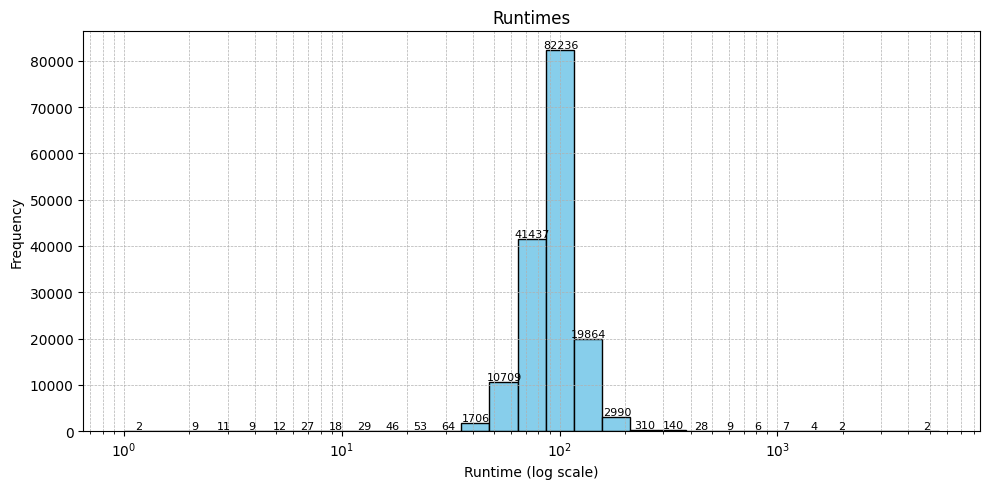

In [24]:
if EXPLORE:
    plot_runtime_histogram(movies)

In [25]:
if EXPLORE:
    show_sorted(movies, ['movie_id', 'runtime', 'year'], 'runtime')
# NOTE: the first one here, "Ekalavya", has a runtime of 138 minutes, not 5,538 (random +90h?); however, the others are accurate... lonk.

                                      movie_id  runtime    year
143026  https://www.imdb.com/title/tt18291334/   5538.0  2022.0
202154   https://www.imdb.com/title/tt5136218/   5460.0  2015.0
224623   https://www.imdb.com/title/tt7321476/   2160.0  2017.0
140163   https://www.imdb.com/title/tt1745901/   1800.0  2010.0
145255   https://www.imdb.com/title/tt1885195/   1669.0  2011.0
213370   https://www.imdb.com/title/tt6127010/   1440.0  2016.0
226202   https://www.imdb.com/title/tt7521772/   1440.0  1993.0
99       https://www.imdb.com/title/tt0004052/   1428.0  1914.0
189051   https://www.imdb.com/title/tt3963450/   1200.0  2010.0
235380   https://www.imdb.com/title/tt8677246/   1100.0  2017.0


In [26]:
if EXPLORE:
    ml_f_runtime = movies.copy()
    ml_f_runtime = ml_f_runtime[(ml_f_runtime['runtime'] >= F_RUNTIME[0]) & (ml_f_runtime['runtime'] <= F_RUNTIME[1])]

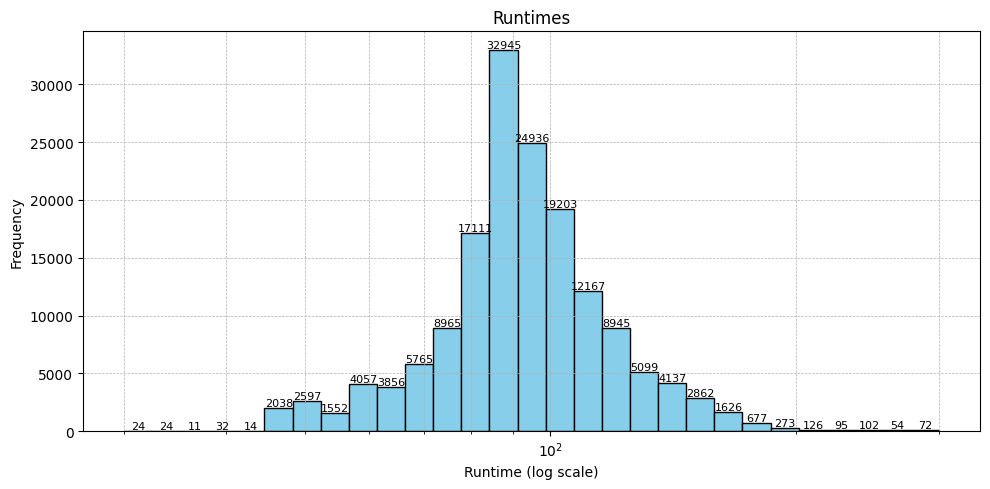

In [27]:
if EXPLORE:
    plot_runtime_histogram(ml_f_runtime)

### Years

In [28]:
def plot_year_histogram(df):
    """
    Plots a histogram of the 'year' column.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the 'year' column.
        bins (int): Number of bins to use in the histogram.
    """
    years = df['year'].dropna()

    year_range = years.max() - years.min()
    bins = int(year_range / 4)

    plt.figure(figsize=(10, 5))
    counts, bins, patches = plt.hist(
        years, bins=bins, align='left',
        color='lightcoral', edgecolor='black'
    )

    # Add labels above bars
    for count, patch in zip(counts, patches):
        if count > 0:
            plt.text(
                patch.get_x() + patch.get_width() / 2,
                count + 0.5,
                str(int(count)),
                ha='center', va='bottom', fontsize=8, rotation=0
            )

    plt.xlabel('Release Year')
    plt.ylabel('Number of Movies')
    plt.title('Histogram of Movie Release Years')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

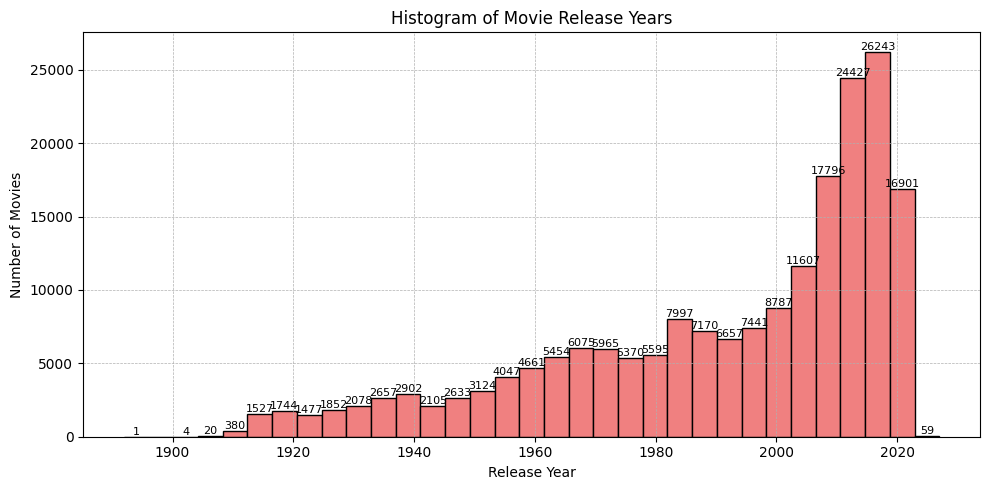

In [29]:
if EXPLORE:
    plot_year_histogram(movies)

In [30]:
if EXPLORE:
    show_sorted(movies, ['movie_id', 'year', 'runtime'], 'year')

                                      movie_id    year  runtime
169811  https://www.imdb.com/title/tt26217400/  2029.0    110.0
169812  https://www.imdb.com/title/tt26217472/  2029.0    115.0
90212   https://www.imdb.com/title/tt10275406/  2029.0      NaN
207724   https://www.imdb.com/title/tt5637536/  2028.0      NaN
90474   https://www.imdb.com/title/tt10300398/  2027.0      NaN
165373   https://www.imdb.com/title/tt2391005/  2027.0      NaN
184753   https://www.imdb.com/title/tt3652896/  2027.0      NaN
104612   https://www.imdb.com/title/tt1204976/  2027.0      NaN
91145    https://www.imdb.com/title/tt1037226/  2027.0      NaN
168213  https://www.imdb.com/title/tt25274186/  2026.0      NaN


In [31]:
if EXPLORE:
    m_f_year = movies.copy()
    # m_f_year = m_f_year[(m_f_year['year'] >= datetime.now().year)]
    m_f_year = m_f_year[(m_f_year['year'] >= F_YEAR[0]) & (m_f_year['year'] <= F_YEAR[1])]
    m_f_year_new = m_f_year[(m_f_year['year'] >= F_YEAR[1])]

In [32]:
if EXPLORE:
    # m_f_year.info()
    m_f_year_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5686 entries, 79943 to 243195
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          5686 non-null   object 
 1   year              5686 non-null   float64
 2   certificate       5686 non-null   int64  
 3   runtime           4469 non-null   float64
 4   rating            3645 non-null   float64
 5   votes             3645 non-null   float64
 6   gross_usd         40 non-null     float64
 7   director_score    3330 non-null   float64
 8   star_score        2911 non-null   float64
 9   genre_action      5686 non-null   int32  
 10  genre_adult       5686 non-null   int32  
 11  genre_adventure   5686 non-null   int32  
 12  genre_animation   5686 non-null   int32  
 13  genre_biography   5686 non-null   int32  
 14  genre_comedy      5686 non-null   int32  
 15  genre_crime       5686 non-null   int32  
 16  genre_drama       5686 non-null   int32  

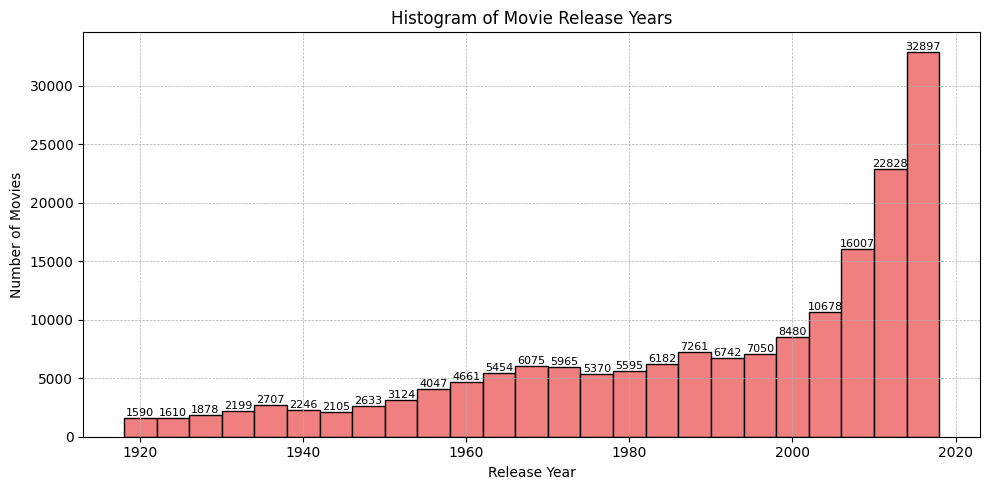

In [33]:
if EXPLORE:
    plot_year_histogram(m_f_year)

### Show Me the Numbahs

In [35]:
if EXPLORE:
    # has_certificate = movies.copy()
    # has_certificate = has_certificate[has_certificate['certificate'].notnull()]

    # has_votes = movies.copy()
    # has_votes = has_votes[has_votes['votes'].notnull()]

    has_gross = movies.copy()
    has_gross = has_gross[has_gross['gross_usd'].notnull()]

In [36]:
if EXPLORE:
    # has_certificate.info()
    # has_votes.info()
    has_gross.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12019 entries, 54 to 243074
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          12019 non-null  object 
 1   year              12019 non-null  float64
 2   certificate       12019 non-null  int64  
 3   runtime           12010 non-null  float64
 4   rating            12019 non-null  float64
 5   votes             12019 non-null  float64
 6   gross_usd         12019 non-null  float64
 7   director_score    10913 non-null  float64
 8   star_score        8543 non-null   float64
 9   genre_action      12019 non-null  int32  
 10  genre_adult       12019 non-null  int32  
 11  genre_adventure   12019 non-null  int32  
 12  genre_animation   12019 non-null  int32  
 13  genre_biography   12019 non-null  int32  
 14  genre_comedy      12019 non-null  int32  
 15  genre_crime       12019 non-null  int32  
 16  genre_drama       12019 non-null  int32  
 

In [37]:
# gross_pre2015 = has_gross.copy()
# gross_pre2015 = gross_pre2015[gross_pre2015['year'] < 2015]

# gross_post2015 = has_gross.copy()
# gross_post2015 = gross_post2015[gross_post2015['year'] >= 2015]

In [38]:
# gross_pre2015.info()
# gross_post2015.info()

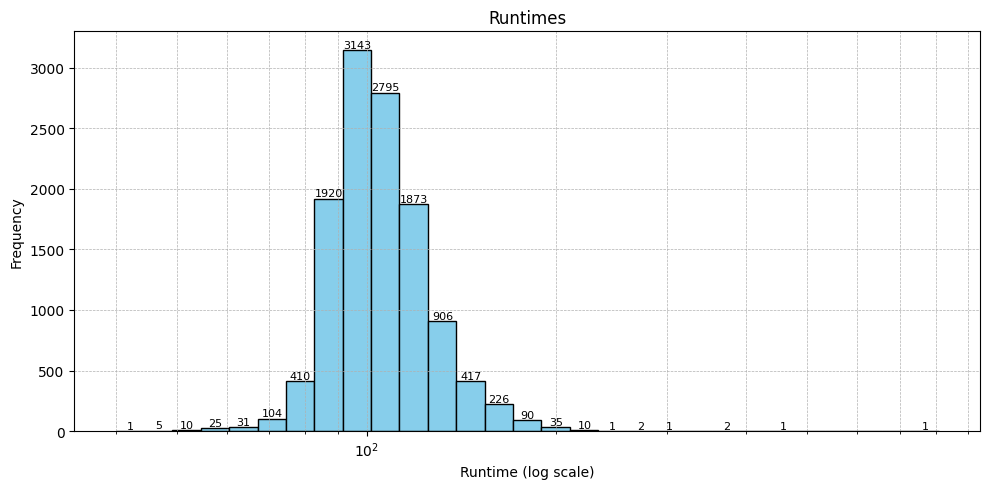

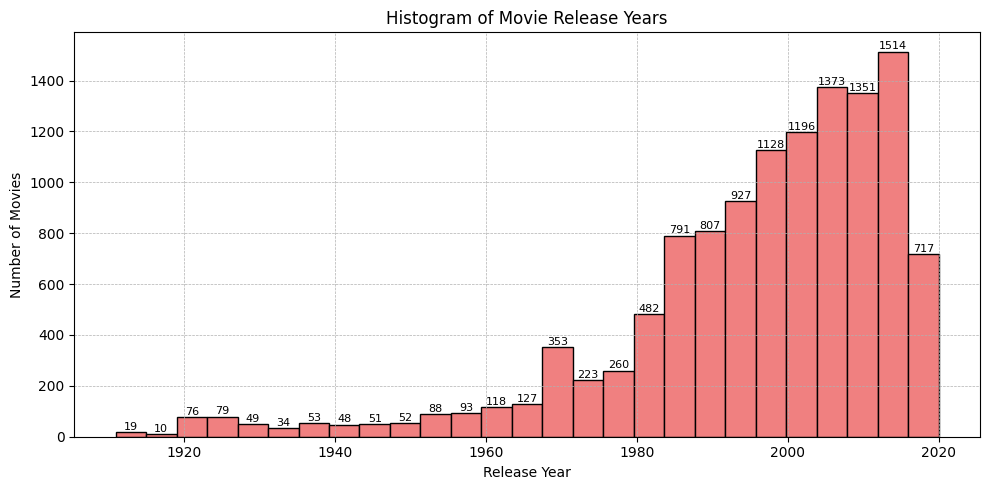

In [39]:
if EXPLORE:
    plot_runtime_histogram(has_gross)
    plot_year_histogram(has_gross)

In [40]:
movies[['certificate']].value_counts()

certificate
0              188040
40              16640
32              13487
1                4898
2                4408
22               4076
15               3837
41               2020
36               1591
25               1369
9                1121
16                704
8                 257
17                144
37                122
6                  86
30                 72
10                 65
5                  42
23                 39
33                 37
35                 30
18                 25
20                 19
28                 14
7                  13
3                   6
38                  5
39                  5
12                  5
26                  4
29                  3
24                  3
19                  3
31                  2
34                  2
21                  2
13                  1
Name: count, dtype: int64

In [41]:
show_sorted(movies, ['movie_id', 'gross_usd'], 'gross_usd')

                                      movie_id    gross_usd
167587   https://www.imdb.com/title/tt2488496/  936662225.0
191131   https://www.imdb.com/title/tt4154796/  858373000.0
95543   https://www.imdb.com/title/tt10872600/  804747988.0
83803    https://www.imdb.com/title/tt0499549/  760507625.0
142684   https://www.imdb.com/title/tt1825683/  700059566.0
191130   https://www.imdb.com/title/tt4154756/  678815482.0
40229    https://www.imdb.com/title/tt0120338/  659325379.0
72245    https://www.imdb.com/title/tt0369610/  652270625.0
85896    https://www.imdb.com/title/tt0848228/  623279547.0
168208   https://www.imdb.com/title/tt2527336/  620181382.0


# Training

In [77]:
df = movies[movies[F_COLS].notna().all(axis=1)].drop(columns=['movie_id'])
df = df[(df['runtime'] >= F_RUNTIME[0]) & (df['runtime'] <= F_RUNTIME[1])]

In [43]:
# df.columns

In [78]:
X = df.drop(columns=['rating'])
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.5, 1, 2]
}

combos = 1
for v in param_dist.values():
    combos *= len(v)

print(f"Total combinations of hyperparameters: {combos}")

Total combinations of hyperparameters: 4860


In [80]:
model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [81]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [82]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

MAE: 0.316
RMSE: 0.497
R² Score: 0.766


## Post-Exploration

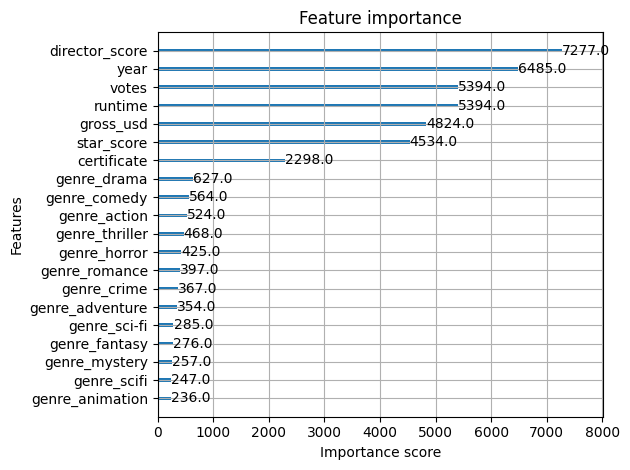

In [83]:
xgb.plot_importance(best_model, max_num_features=20)
plt.tight_layout()
plt.show()

In [135]:
def plot_features_vs_rating(df, columns):
    def _plot_feature_vs_rating(df, column):
        # Drop NA values
        subset = df[[column, 'rating']].dropna()
        
        # Get min and max of the column
        min_val, max_val = subset[column].min(), subset[column].max()

        # Define bin edges and labels
        bins = np.linspace(min_val, max_val, 100)
        labels = (bins[:-1] + bins[1:]) / 2  # Midpoint labels

        # Cut the data into bins
        subset['bin'] = pd.cut(subset[column], bins=bins, labels=labels, include_lowest=True)
        
        # Group by bin and take mean rating
        grouped = subset.groupby('bin', observed=True)['rating'].mean().reset_index()
        grouped['bin'] = grouped['bin'].astype(float)

        # Drop NaNs in case there are any gaps in grouped['rating']
        cleaned = grouped.dropna()

        X_linreg = cleaned['bin'].values.reshape(-1, 1)
        y_linreg = cleaned['rating'].values

        # Fit linear regression
        reg = LinearRegression().fit(X_linreg, y_linreg)
        y_pred = reg.predict(X_linreg)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(cleaned['bin'], y_pred, color='orange', linestyle='--', label='Linear trend')
        plt.legend()
        plt.plot(grouped['bin'], grouped['rating'], color='teal', label='Mean rating')
        plt.title(f'Average Rating vs {column}')
        plt.xlabel(column)
        plt.ylabel('Average Rating')
        # plt.ylim(0, 10)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    for column in columns:
        _plot_feature_vs_rating(df, column)

In [ ]:
plot_features_vs_rating(df, ['director_score', 'year', 'votes', 'runtime', 'gross_usd', 'certificate', 'star_score'])

In [167]:
def plot_predictions(y_true, y_pred):
    error = np.abs(y_true - y_pred)

    df_plot = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': error
    })

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(
        df_plot['Actual'],
        df_plot['Predicted'],
        c=df_plot['Error'],
        cmap='viridis',
        alpha=0.6,
        edgecolors='w',
        linewidths=0.2
    )

    plt.plot([0, 10], [0, 10], color='black', linestyle='--', label='Perfect Prediction')
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title("Predictions vs Actual Ratings (Colored by Error)")
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.legend()
    plt.grid(True)

    # Colorbar to show what the colors mean
    cbar = plt.colorbar(scatter)
    cbar.set_label('Absolute Error')

    plt.tight_layout()
    plt.show()

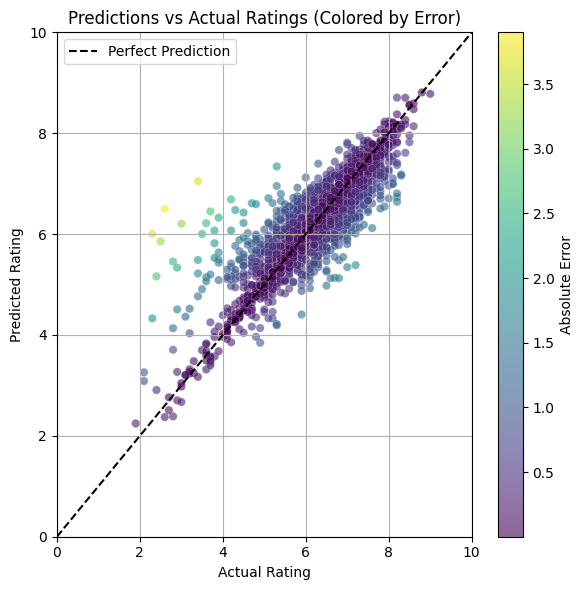

In [168]:
plot_predictions(y_test, y_pred)